<a href="https://colab.research.google.com/github/dlmacedo/deep-learning-class/blob/master/notebooks/pytorch/Transformer_Illustration_and_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

This notebook combines the excellent [illustration](http://jalammar.github.io/illustrated-transformer/) of the [transfomer](https://arxiv.org/abs/1706.03762) by Jay Alammar and the [code annonation](http://nlp.seas.harvard.edu/2018/04/03/attention.html) by `harvardnlp` lab.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
%matplotlib inline

---

## Part 1: Components of the transformer model

### Step 1: EncoderDecoder and Generator models

![](http://jalammar.github.io/images/t/The_transformer_encoders_decoders.png)

At this point now we don't bother about how `self.decoder` and `self.encoder` are implemented.

In [2]:
class EncoderDecoder(nn.Module):
    '''
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    '''
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        memory = self.encoder(self.src_embed(src), src_mask)
        return self.decoder(memory, src_mask, tgt, tgt_mask)

---

### Step 2: Encoder and decoder stacks

The encoder and decoder shown above are actually stacks of multiple (six to be precise) encoders and decoders:

![](http://jalammar.github.io/images/t/The_transformer_encoder_decoder_stack.png)

Since the layers are identical, we first write a function to create identical copies of any `module`:

In [3]:
def clones(module, N):
    return nn.ModuleList([ copy.deepcopy(module) for _ in range(N) ])

Then we implement the encoder. It is simply a stack of `N=6` identical layers plus a `LayerNorm` layer. Don't worry about it for now. We will see later how it is implemented.

In [4]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

A decoder does the same thing at a high level:

In [5]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

---

### Step 3: Looking into an encoder

An encoder has two sub-layers (self-attention and feed forward) like so:

![](http://jalammar.github.io/images/t/Transformer_encoder.png)

The feed forward layer simply is a collection of linear layers:

![](http://jalammar.github.io/images/t/encoder_with_tensors_2.png)

Note that the self-attention layer uses the inputs x<sub>1</sub>, x<sub>2</sub>, ... to calculate how much attention to pay to each input. However the linear transformations z<sub>1</sub> → r<sub>1</sub>, z<sub>2</sub> → r<sub>2</sub>, ... are all independent of each other. Hence this part can be parallelized.

#### 3.1 Residuals and normalization

After each sub-layer of an encoder, we add to the output the input and then apply layer normalization to it:

![](http://jalammar.github.io/images/t/transformer_resideual_layer_norm.png)

> ### To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension d<sub>model</sub>=512. 
<sub>[source](http://nlp.seas.harvard.edu/2018/04/03/attention.html)</sub>

Let's implement the `LayerNorm` now:

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, features_size, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.scale = nn.Parameter(torch.ones(features_size))
        self.shift = nn.Parameter(torch.zeros(features_size))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdims=True)
        std = x.std(-1, keepdims=True)
        return (x - mean) * scale / (std + self.eps) + shift

Next we implement the layer in green above which says `Add & Normalize`. It takes as function a `sublayer` and the input `x` to the sublayer. Then it calculates `x + sublayer(x)` and then normalizes it. However we do two things differently here:

1. We apply layer normalization to `x` before feeding it to `sublayer`.
2. We apply dropout to the output of `sublayer` before adding `x` to it.

In [7]:
class SubLayerConnection(nn.Module):
    def __init__(self, features_size, dropout):
        super(SubLayerConnection, self).__init__()
        self.norm = LayerNorm(features_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

Now let's create the encoder layer which contains the following layers as shown below:
- Self attention layer
- Add and normalize layer
- Feed forward layer
- Another add and normalize layer

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayers = clones(SubLayerConnection(size, dropout), 2)
        
    def forward(self, x, mask):
        attn_function = lambda x: self.self_attn(x, x, x, mask)
        x = self.sublayers[0](x, attn_function)
        return self.sublayers[1](x, self.feed_forward)

Note that `mask` is only used by the `self_attn` layer in the class above. We still don't know how `self_attn` works. Let's look into how it works.

---

### Step 4: Self attention

Each input vector v<sub>i</sub> to an encoder layer undergoes three different linear transformations to create three different vectors: query<sub>i</sub>, key<sub>i</sub> and value<sub>i</sub>.

To calculate the attention for the word corresponding to the first index `(i=0)`, we calculate:

< query<sub>0</sub>, key<sub>i</sub> > * value<sub>i</sub> for all `i` where `<a,b>` represents a dot product.

Then we add all these vectors up:

Σ<sub>i</sub>  value<sub>i</sub> * < query<sub>0</sub>, key<sub>i</sub> >

However there are some details between these steps:
- While the input (and output) vectors have dimension = 512, query<sub>i</sub>, key<sub>i</sub> and value<sub>i</sub> vectors have dimension = 64
- After calculating the dot product < query<sub>0</sub>, key<sub>i</sub> >, the output is divided by √(dimension of output vector) = √64 = 8 

  Scale values by < query<sub>0</sub>, key<sub>i</sub> > / 8
  

- [Optional] A mask is applied to the values above. As we will see below, the mask is required only by the decoder, not by the encoder.
- A softmax is taken over all values < query<sub>0</sub>, key<sub>i</sub> > / 8
- The output of the softmax is then multiplied elementwise to the value<sub>i</sub> vectors.

This is shown nicely in the illustration below:

![](http://jalammar.github.io/images/t/self-attention-output.png)


All of this can be condensed into one step as shown (here a vector is represented in a row form):

![](http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png)

Now let's implement this. Assuming we have `query`, `key` and `value` vectors, we implement the visual shown below:

![](http://nlp.seas.harvard.edu/images/the-annotated-transformer_33_0.png)

In [9]:
def attention(query, key, value, mask=None, dropout=None):
    '''
    query, key and value contain vectors corresponding to each word in the input
    '''
    sqrt_d_k = math.sqrt(query.size(-1))
    scores = torch.matmul(query, key.transpose(-2,-1)) / sqrt_d_k
    
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
        
    prob_scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        p_attn = dropout(prob_scores)
    
    scaled_value = torch.matmul(prob_scores, value)
    return scaled_value, prob_scores

---

### Step 5: Multi-headed attention

Note that the output vector (`value`) corresponding to each input vector has dimension = 64. We know that the input and output vectors of the `EncoderLayer` have dimension = 512. So what happens after the self-attention step? 

Well, we have eight copies of self-attention which produce eight output vectors each of dimension = 64 for each input vector of dimension = 512. When we concatenate them, we get an output vector of dimension = 64 * 8 = 512. This is then fed to a linear layer called W<sup>o</sup>.

Each "copy" is self-attention is called an attention head. We have eight attention heads here. Each attention head learns a different attention.

![](http://jalammar.github.io/images/t/transformer_attention_heads_qkv.png)

---

![](http://jalammar.github.io/images/t/transformer_attention_heads_z.png)

---

![](http://jalammar.github.io/images/t/transformer_attention_heads_weight_matrix_o.png)


This can also be shown as:

![](http://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png)

Note that for each attention head, we have an input with shape _something_ like:
```
(batch size, words in each input, 64)
```

Now that we have multiple heads, we want the input tensor to have _something_ like:
```
(batch size, number of attention heads, words in each input, 64)
```

This is how it is done:

- `head 1` converts `x` (dim=512) into `query1` (dim=64). This is a linear transformation `nn.Linear(512, 64)`
- `head 2` converts `x` (dim=512) into `query2` (dim=64). This is a linear transformation `nn.Linear(512, 64)`
...
- `head 8` converts `x` (dim=512) into `query8` (dim=64). This is a linear transformation `nn.Linear(512, 64)`

We can do implement of the above individual head calculations using a single linear transformation `nn.Linear(512, 512)`. This will give us a vector with `query1, query2, ..., query8` concatenated in a vector of dimension = 512. Let's call the layer that does this transformation `L1`.

Similarly we can do another linear transformation `nn.Linear(512, 512)` which gives us a vector with `key1, key2, ..., key8` concatenated. Let's call this layer `L2`.

And a third linear transformation `nn.Linear(512, 512)` which gives us a vector with `value1, value2, ..., value8` concatenated. Let's call this layer `L3`.

For each output (`query`, `key` and `value`) we perform the following steps:

- We change the shape of each output tensor to 
```
(batch size, words in each input, number of attention heads, 64)
```

- Then we transpose the dimensions of the tensor to get a tensor with size:
```
(batch size, number of attention heads, words in each input, 64)
```

Then we perform attention by calling the `attention` function above.

In [10]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, num_heads, dim_input=512, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert dim_input % num_heads == 0
        self.num_heads = num_heads
        self.dropout = nn.Dropout(p=dropout)
        self.d_k = dim_input // num_heads
        
        # L1, L2, L3 and W0: four linear layers in all
        self.linears = clones(nn.Linear(dim_input, dim_input), 4)
        
        # this is used to store the prob_scores, just for visualization
        self.attn = None
        
        # helper function to resize the tensor as described above
        self.resize_tensor = lambda tensor: tensor.view(batch_size, -1, self.num_heads, self.d_k).transpose(1,2)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1) # same mask is applied to all heads
        batch_size = query.size(0)
        
        # use the first three linear layers to transform query, key and value
        zipped = zip(self.linears, (query, key, value))
        query, key, value = [self.resize_tensor(linear(x)) for (linear, x) in zipped]
        
        # apply self attention
        scaled_value, self.attn = attention(query, key, value, mask, self.dropout)
        scaled_value = scaled_value.transpose(1,2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.linears[-1](scaled_value)

---

At this point let us take a pause and take a stock of things we have and have not covered yet.

Things we have covered:
- An encoder has two layers: self-attention and feed-forward
- How self-attention works
- How multi-headed self-attention works

Things we have not covered:
- How many layers does a decoder have
- How do those layers work?

Let's start by looking into a decoder

### Step 6: Looking into a decoder

Each decoder has three sub-layers:
1. Self-attention
2. Encoder-decoder attention
3. Feed forward

![](http://jalammar.github.io/images/t/Transformer_decoder.png)

As in an encoder layer, we perform `Add + Layernormalize` operation after each of these layers. Here is how the whole picture looks:

![](http://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png)

Let's not worry about how each sub-layer inside a decoder works and just implement how these layers interact with each other inside a decoder:

In [11]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, enc_dec_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        # enc_dec_attn is also called src_attn in the harvardnlp implementation
        self.self_attn = self_attn
        self.enc_dec_attn = enc_dec_attn
        self.feed_forward = feed_forward
        self.sublayers = clones(SubLayerConnection(size, dropout), 3)
        # we need to store size because it is used by LayerNorm in Decoder
        self.size = size
        
    def forward(self, x, encoder_outputs, src_mask, tgt_mask):
        # encoder_outputs are also called `memory` in the paper
        x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayers[1](x, lambda x: self.enc_dec_attn(x, encoder_outputs, encoder_outputs, src_mask))
        return self.subayers[2](x, self.feed_forward)

### 6.1 Understanding self-attention mask in a decoder layer

Note the first step:
```python
x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
```

It looks the self-attention in encoder. The only difference here is how the `tgt_mask` is defined. When the decoder is decoding at time step `t`, it should not attend to any vectors which are ahead in time (`time > t`). Thus, when decoding for the first time step, it should not consider any vectors at time steps `2,3,..`. We implement this using a mask (`tgt_mask`). 

> We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position _i_ can depend only on the known outputs at positions less than _i_.
<sub>[source](http://nlp.seas.harvard.edu/2018/04/03/attention.html)</sub>

This is how it is implemented:

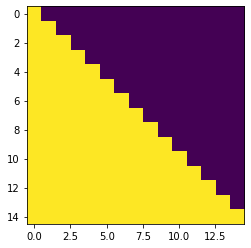

In [12]:
subsequent_mask = lambda size: torch.from_numpy(np.tril(np.ones((1,size,size)))) > 0

# Let's take a look at how it looks
plt.imshow(subsequent_mask(15)[0])

Now refer back to the below lines in the implementation of `attention` function:

```python
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
        
    prob_scores = F.softmax(scores, dim=-1)
```

Thus after the softmax operation all the position which are 0 in the mask will be zero as well. The corresponding `value` vectors will then become zero vectors.


### 6.2 Understanding encoder-decoder attention in a decoder layer

Now look at the below line of code:

```python
x = self.sublayers[1](x, lambda x: self.enc_dec_attn(x, encoder_outputs, encoder_outputs, src_mask))
```

In this case the `query` vector is the vector `x` that will eventually predict the output word. The `key` and `value` vectors come from the output of the encoder stack. Thus we are still scaling the encoder output vectors but they are _queried_ by `x`.

> The encoder start by processing the input sequence. The output of the top encoder is then transformed into a set of attention vectors K and V. These are to be used by each decoder in its “encoder-decoder attention” layer which helps the decoder focus on appropriate places in the input sequence.

> ...

> The “Encoder-Decoder Attention” layer works just like multiheaded self-attention, except it creates its Queries matrix from the layer below it, and takes the Keys and Values matrix from the output of the encoder stack.
<sub>[source](http://jalammar.github.io/illustrated-transformer/)</sub>

![](http://jalammar.github.io/images/t/transformer_decoding_1.gif)

---

### Step 7: Linear + Softmax on the output of decoder layer

Notice the `Linear + Softmax` layer in the `.gif` image above? It simply maps each _decoded_ vector to another vector whose dimension = vocabulary size. Then a softmax operation simply tells us which word to pick.

The `[Linear + Softmax]` layer takes as input the output from decoders. It is implemented in class `Generator` below.

In [13]:
class Generator(nn.Module):
    '''Linear + Softmax generation step'''
    def __init__(self, d_model, vocab_len):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab_len)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

---

### Step 8: Feed forward sub-layer in encoders and decoders

The feed-forward sub-layer in each encoder and decoder is actually a set where each item is `[Linear layer, ReLU, Linear layer]`. Each item i v<sub>t</sub>  performs this transformation for the corresponding vector v<sub>t</sub> for all time steps `t`:

![](http://jalammar.github.io/images/t/encoder_with_tensors_2.png)

> In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.
<sub>[source](http://nlp.seas.harvard.edu/2018/04/03/attention.html)</sub>

In [14]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, input_size=512, output_size=2048, dropout=0.1):
        super(PositionWiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(input_size, output_size)
        self.linear2 = nn.Linear(output_size, input_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

---

### Step 9: Positional Encoding

> One thing that’s missing from the model as we have described it so far is a way to account for the order of the words in the input sequence.
<sub>[source](http://jalammar.github.io/illustrated-transformer/)</sub>

> Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add “positional encodings” to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension `dim_model` as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned and fixed.

> ...

> We also experimented with using learned positional embeddings (cite) instead, and found that the two versions produced nearly identical results. We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.
<sub>[source](http://nlp.seas.harvard.edu/2018/04/03/attention.html/)</sub>

This is shown in the visual below:

![](http://jalammar.github.io/images/t/transformer_positional_encoding_vectors.png)

One thing that is not shown in the visual above is that we apply dropout to the sum of embedding and positional encoding.

For implementing positional encoding we need to know three things:
1. Length of word embedding `(= 512)`
2. Dropout rate `(= 0.1)`
3. Maximum length of sequence.

### 9.1 Formulae for positional encoding 

Given an embedding at position `pos`, 

* an even index (`2i`-th index) of the corresponding positional encoding is given by:
  * PE<sub>pos, 2i</sub> = sin(pos * C<sup>-2i/(len_of_embedding)</sup>) 
  
  
* an odd index (`2i+1`-th index) of the corresponding positional encoding is given by:
  * PE<sub>pos, 2i+1</sub> = cos(pos * C<sup>-2i/(len_of_embedding)</sup>) 
  
where `C` = 10000 and `pos` is zero-indexed (i.e. counting the position starts from 0)

Let us simply by saying `L` = `len_of_embedding` and `C` = 1000.

Then we have:

log ( C<sup>-2i/(len_of_embedding)</sup> ) = -(2i/N) \* log(C) = 2i \* (-log(C) / N)

Therefore:<br/>
C<sup>-2i/(len_of_embedding)</sup> = exp( 2i \* (-log(C) / N) )

This is how we calculate the arguments to `sin` and `cosine` functions. Also we want to store the positional embeddings in the state dict even though it is not something that is learable (i.e. it is not a parameter). We can do so by calling `register_buffer`:

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_embedding, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        positional_encodings = torch.zeros(max_len, dim_embedding)
        positions = torch.arange(0, max_len).unsqueeze(1).float()
        
        # calculate the arguments for sin and cos functions
        scale = -(math.log(10000) / dim_embedding)
        arguments = torch.arange(0, dim_embedding, 2).float() * scale
        arguments = torch.exp(arguments)
        arguments = positions * arguments
        
        # define the encodings here
        positional_encodings[:, 0::2] = torch.sin(arguments)
        positional_encodings[:, 1::2] = torch.cos(arguments)
        
        positional_encodings = positional_encodings.unsqueeze(0)
        self.register_buffer('positional_encodings', positional_encodings)
        
    def forward(self, x):
        pos_enc = self.positional_encodings[:, :x.size(1)]
        pos_enc.requires_grad_(False)
        x  = x + pos_enc
        return self.dropout(x)

Let's take a look at some of the positional encodings:

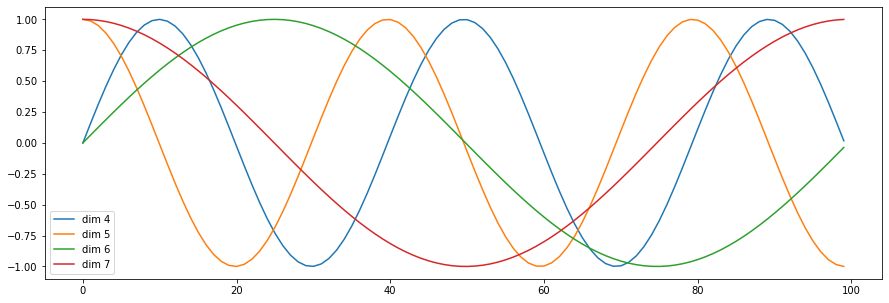

In [16]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20,0)
y = pe(torch.zeros(1,100,20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

This is what these positional encodings look with dropout:

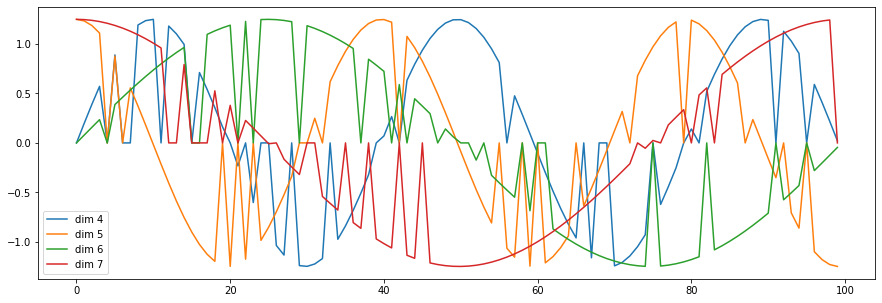

In [17]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20,0.2)
y = pe(torch.zeros(1,100,20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

---

### Step 10: Words to learnable embeddings

Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension `dim_model` or `dim_embedding`.

In [18]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, dim_embedding):
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, dim_embedding)
        self.scale = math.sqrt(dim_embedding)
        
    def forward(self, x):
        # embedding is multiplied by scale to make the positional encoding relatively smaller
        # See: https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec
        return self.embed(x) * self.scale

That's it. We have implemented all the components that constitute the transformer model. Now let's put them all together and create a model.

---

## Part 2: Full transformer model

In [19]:
def make_model(src_vocab, tgt_vocab, num_enc_dec=6, dim_model=512, dim_feedfwd=2048, attn_heads=8, dropout=0.1):
    # prepare the embeddings for encoder and decoder stacks
    position_embeddings = PositionalEncoding(dim_model, dropout)
    src_embed = nn.Sequential(Embedding(src_vocab, dim_model), copy.deepcopy(position_embeddings))
    tgt_embed = nn.Sequential(Embedding(tgt_vocab, dim_model), copy.deepcopy(position_embeddings))
    
    # prepare reusable layers. we will copy.deepcopy them whenever needed
    attn_layer = MultiHeadedAttention(attn_heads, dim_model)
    feed_fwd_layer = PositionWiseFeedForward(dim_model, dim_feedfwd, dropout)
    c = copy.deepcopy
    
    # prepare the encoder stack
    encoder_layer = EncoderLayer(dim_model, c(attn_layer), c(feed_fwd_layer), dropout)
    encoder = Encoder(encoder_layer, num_enc_dec)
    
    # prepare the decoder stack
    decoder_layer = DecoderLayer(dim_model, c(attn_layer), c(attn_layer), c(feed_fwd_layer), dropout)
    decoder = Decoder(decoder_layer, num_enc_dec)
    
    # prepare the generator
    generator = Generator(dim_model, tgt_vocab)
    
    # creat the model
    model = EncoderDecoder(encoder, decoder, src_embed, tgt_embed, generator)
    
    # Initialize parameters using Xavier initialization
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
            
    return model

Let's create a small model which source and target vocabulary sizes of 10 and only two encoders/decoders in an encoder/decoder stack. Even for this small a model, the number of parameters is a staggering ~14 million.

In [20]:
small_transformer = make_model(src_vocab=10, tgt_vocab=10, num_enc_dec=2)
sum( [param.numel() for param in small_transformer.parameters()] )

14730250

Also note how a multi-headed attention in a model looks like. It's little more than a bunch of linear transformations and concatenation.

In [21]:
small_transformer.encoder.layers[0].self_attn

MultiHeadedAttention(
  (dropout): Dropout(p=0.1, inplace=False)
  (linears): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
)